In [1]:
!pip install tensorflow-gpu==2.0.0-rc0

     |████████████████████████████████| 380.5 MB 36 kB/s 
     |████████████████████████████████| 4.3 MB 39.9 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 501 kB 73.4 MB/s 


### Importing necessary Libraries

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D,MaxPool1D,Dropout,BatchNormalization,Flatten,Dense
from tensorflow.keras.optimizers import Adam

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Loading the Breast Cancer Data

In [5]:
d_Data=load_breast_cancer()
d_Data

{'DESCR': '.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry \n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        largest values) of these features were computed for each image,\n        resulting in 30 features.  For

In [6]:
x_train,x_test,y_train,y_test= train_test_split(d_Data.data,d_Data.target,test_size=0.2,stratify=d_Data.target)
x_train.shape , x_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

### Scaling the data

In [7]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)
x_train=x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test=x_test.reshape((x_test.shape[0],x_test.shape[1],1))

### Building the Neural Network Model 

In [8]:
model= Sequential()
model.add(Conv1D(32,2,activation='relu',padding='same',input_shape=x_train[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,2,activation='relu',padding='same',input_shape=x_train[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 32)            96        
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 30, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 64)            4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 64)            256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0

### Callback function to stop the model from overfitting

In [9]:
# Define a Callback class that stops training once training_accuracy becomes >= validation_accuracy
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=logs.get('val_accuracy')):
      print("\nReached Training accuracy of: {}".format(logs.get('accuracy')))
      print("\nReached Validation accuracy of: {}".format(logs.get('val_accuracy')))
      print("\nNow that our training_accuracy has already reached >= validation_accuracy, we should stop the training!!!")
      self.model.stop_training = True

### Write functions for Prediction and Evaluation criteria

In [10]:
def predict(model,x2_test):
    pred=model.predict(x2_test)
    final_pred=[]
    for arr in range(len(pred)):
        final_pred=np.append(final_pred,(pred[arr][0] > 0.5).astype("int32"))
    return final_pred

def plot_confusion_matrix(actual_target_list,predicted_target_list,classes_list,axis_notation_list=[]):
    if len(axis_notation_list)==0:
      axis_notation_list=classes_list
    conf_mat=[]
    actual_target_list=list(actual_target_list)
    for aclass in classes_list:
        row_list=[]
        for pclass in classes_list:
            row_list.append(sum(pd.Series(predicted_target_list)[pd.Series(actual_target_list)==aclass]==pclass))
        conf_mat.append(row_list)
    hw=len(classes_list)*1.5
    fig, ax = plt.subplots(figsize=(hw,hw/2))
    heatmap=sns.heatmap(conf_mat,
            xticklabels=axis_notation_list,yticklabels=axis_notation_list,
            annot=True,cbar=False,ax=ax,fmt='g',cmap='Blues',
                       linewidths=0.3, linecolor='black')


    ax.set(xlabel='Predicted',ylabel='Actual')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    plt.show()
    return conf_mat

def plot_experimental_results(conf_matrix_list):
    TP=conf_matrix_list[1][1]
    FP=conf_matrix_list[0][1]
    TN=conf_matrix_list[0][0]
    FN=conf_matrix_list[1][0]
    
    Recall=TP/(TP+FN)
    FP_rate=FP/(FP+TN)
    Precision=TP/(TP+FP)
    F1_measure=2*Precision*Recall/(Precision+Recall)
    
    plt.subplots(figsize=(4,4))
    plt.bar([0.3,1.3,2.3,3.3],[Recall,FP_rate,Precision,F1_measure],0.3)
    the_table = plt.table(cellText=[[Recall,FP_rate,Precision,F1_measure]],
                      rowLabels=['Value'],
                      colLabels=('Recall','FP Rate','Precision','F-Measure'),
                     loc='bottom')
    plt.subplots_adjust(left=0,right=2,top=1, bottom=0)
    plt.xticks([])

def plot_learning_curve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model_Accuracy')
    plt.legend(['Train','Validate'],loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model_loss')
    plt.legend(['Train','Validate'],loc='upper left')
    plt.show()

### Compile the model

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

### Train the model

In [12]:
callbacks=myCallback()
history=model.fit(x_train,y_train, batch_size= 2, epochs= 30, verbose=1, validation_data=(x_test,y_test),callbacks=[callbacks])

Train on 455 samples, validate on 114 samples
Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
455/455 [==============================] - 3s 6ms/sample - loss: 0.4641 - accuracy: 0.7824 - val_loss: 0.3824 - val_accuracy: 0.7895
Epoch 2/30
436/455 [===========================>..] - ETA: 0s - loss: 0.2008 - accuracy: 0.9220
Reached Training accuracy of: 0.9186813235282898

Reached Validation accuracy of: 0.8859649300575256

Now that our training_accuracy has already reached >= validation_accuracy, we should stop the training!!!
455/455 [==============================] - 1s 3ms/sample - loss: 0.2025 - accuracy: 0.9187 - val_loss: 0.2601 - val_accuracy: 0.8860


In [13]:
y_pred=predict(model,x_test)

In [14]:
y_pred

array([1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.])

### Plot Confusion matrix and other relevant Evaluation metrics

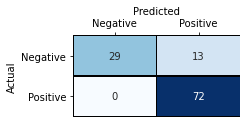

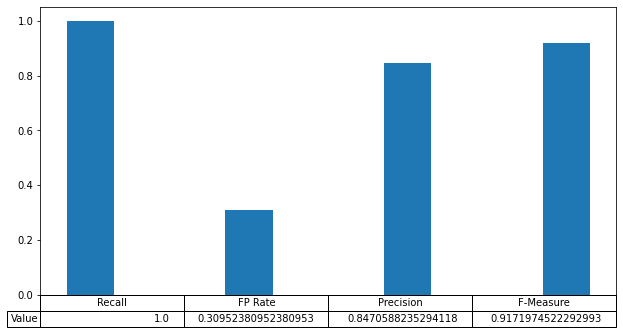

In [15]:
plot_experimental_results(plot_confusion_matrix(y_test,y_pred,[0,1],['Negative','Positive']))

### Plot Learning curve

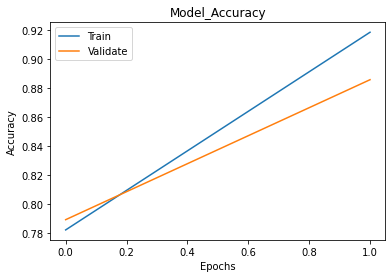

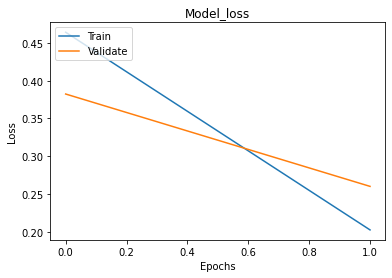

In [16]:
plot_learning_curve(history)